In [1]:
#pip install easydict pandas tqdm Pillow matplotlib

In [1]:
import os
import gc
import copy

import numpy as np
import pandas as pd

import easydict
from tqdm import notebook

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms

import timm

## Config


In [2]:
config = {}

config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"

config['num_workers'] = 0
config['pin_memory'] = True

config['hidden_dim'] = 128
config['dropout'] = 0.1

config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5

args = easydict.EasyDict(config)

## Data

In [3]:
root_path = '.\\data'
TRAIN_PATH = os.path.join(root_path, 'train')
TEST_PATH = os.path.join(root_path, 'test')

label2idx = {
    'dog' : 0,
    'elephant' : 1,
    'giraffe' : 2,
    'guitar' : 3,
    'horse' : 4,
    'house' : 5,
    'person' : 6
}

idx2label = { v : k for k, v in label2idx.items()}
#{0: 'dog', 1: 'elephant', 2: 'giraffe', 
#3: 'guitar', 4: 'horse', 5: 'house', 6: 'person'}

## Train

In [4]:
labels = []

for path in os.walk(TRAIN_PATH) :
    label_type = path[0].split('\\')[-1]
    print(label_type)
    if label_type == 'train' :
        continue
        
    base_path = path[0]
    images = path[2]
    
    idx = label2idx[label_type]
    for image in images :
        img_path = os.path.join(base_path, image)
        label = {'img_path' : img_path,
                'label' : idx}
        labels.append(label)
        

train_df = pd.DataFrame(labels)
train_df = train_df.sort_values(['label', 'img_path'])
train_df = train_df.reset_index(drop=True)
train_df

train
dog
elephant
giraffe
guitar
horse
house
person


,img_path,label
0,.\data\train\dog\pic_001.jpg,0
1,.\data\train\dog\pic_002.jpg,0
2,.\data\train\dog\pic_003.jpg,0
3,.\data\train\dog\pic_004.jpg,0
4,.\data\train\dog\pic_005.jpg,0
...,...,...
1693,.\data\train\person\pic_506.jpg,6
1694,.\data\train\person\pic_507.jpg,6
1695,.\data\train\person\pic_508.jpg,6
1696,.\data\train\person\pic_510.jpg,6


## Test

In [5]:
labels = []
for path in os.walk(TEST_PATH) :
    base_path = path[0]
    images = path[2]
    
    for image in images :
        img_path = os.path.join(base_path, image)
        label = {'img_path' : img_path,
                'label' : -1}
        labels.append(label)
    
test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df = test_df.reset_index(drop=True)
test_df

,img_path,label
0,.\data\test\0\0001.jpg,-1
1,.\data\test\0\0002.jpg,-1
2,.\data\test\0\0003.jpg,-1
3,.\data\test\0\0004.jpg,-1
4,.\data\test\0\0005.jpg,-1
...,...,...
345,.\data\test\0\0346.jpg,-1
346,.\data\test\0\0347.jpg,-1
347,.\data\test\0\0348.jpg,-1
348,.\data\test\0\0349.jpg,-1


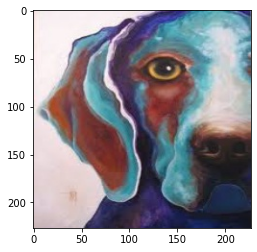

In [6]:
image = plt.imread(train_df['img_path'][0])
plt.imshow(image)

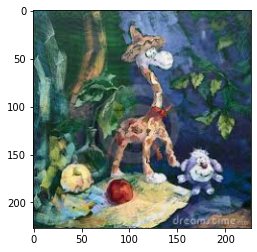

In [7]:
image = plt.imread(test_df['img_path'][0])
plt.imshow(image)

In [8]:
train_df.groupby('label').count()

,img_path
label,
0,329
1,205
2,235
3,134
4,151
5,245
6,399


In [9]:
test_df.count()

img_path    350
label       350
dtype: int64

In [10]:
class ArtDataset(Dataset) :
    def __init__(self, df, transform=None) :
        self.df = df
        self.transform = transform
        
    def __getitem__(self, idx) :
        data = self.df.iloc[idx]
        
        img_path = data['img_path']
        image = Image.open(img_path)
        
        if self.transform :
            image = self.transform(image)
        
        
        label = data['label']
        
        return image, label
    
    def __len__(self):
        return len(self.df)

In [11]:
transform = transforms.Compose([transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])

dataset = ArtDataset(train_df, transform)
loader = DataLoader(dataset, shuffle=True, batch_size=32)

In [12]:
from sklearn.model_selection import StratifiedKFold

def split_df(df, kfold_n=5) :
    kfold = StratifiedKFold(n_splits=kfold_n)
    
    # 모든 img_path 값
    x = df.img_path.values
    # 모든 label 값
    y = df.label.values
    
    datas = []
    for i, (train_idx, valid_idx) in enumerate(kfold.split(x, y)) :
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        valid_df = df.iloc[valid_idx].copy().reset_index(drop=True)
        
        datas.append((train_df, valid_df))
    
    return datas

### datas[0][0] = train

In [13]:
datas = split_df(train_df)
datas[0][0].groupby('label').count()

,img_path
label,
0,263
1,164
2,188
3,107
4,121
5,196
6,319


### datas[0][1] = valid

In [14]:
datas[0][1].groupby('label').count()

,img_path
label,
0,66
1,41
2,47
3,27
4,30
5,49
6,80


In [15]:
def get_loader(train_data, valid_data, transform) :
    train_dataset = ArtDataset(train_data, transform)
    valid_dataset = ArtDataset(valid_data, transform)
    
    train_loader = DataLoader(train_dataset,
                             shuffle=True,
                             num_workers=args.num_workers,
                             batch_size=args.batch_size,
                             pin_memory=args.pin_memory)
    
    valid_loader = DataLoader(valid_dataset,
                             shuffle=False,
                             num_workers=args.num_workers,
                             batch_size=args.batch_size,
                             pin_memory=args.pin_memory)
    
    return train_loader, valid_loader

# Model
- efficientNet b1
- ViT


In [16]:
for x, y in loader :
    print(x.size(), y.size())
    print(x, y)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([[[[ 0.0398,  0.2111,  0.1426,  ..., -0.2342, -0.3027, -0.3198],
          [ 0.0398,  0.2111,  0.1426,  ..., -0.2171, -0.2856, -0.3198],
          [ 0.0398,  0.2111,  0.1426,  ..., -0.1828, -0.2513, -0.3027],
          ...,
          [ 1.7009,  1.7180,  1.7180,  ...,  1.4098,  1.0159,  0.7591],
          [ 1.7523,  1.7523,  1.7694,  ...,  0.5536,  0.4851,  1.0844],
          [ 1.7523,  1.7694,  1.7694,  ...,  0.9303,  1.1187,  1.7180]],

         [[ 0.4153,  0.5903,  0.5378,  ...,  0.1352,  0.0826,  0.0651],
          [ 0.4153,  0.5903,  0.5378,  ...,  0.1527,  0.1001,  0.0651],
          [ 0.4153,  0.5903,  0.5378,  ...,  0.1877,  0.1352,  0.0826],
          ...,
          [ 2.0784,  2.0959,  2.0959,  ...,  1.7283,  1.3431,  1.0805],
          [ 2.0959,  2.0959,  2.1134,  ...,  0.9055,  0.8354,  1.4482],
          [ 2.0959,  2.1134,  2.1134,  ...,  1.3256,  1.4832,  2.0959]],

         [[ 0.6531,  0.8274,  0.8448,  ...,  0.4091,  0

In [17]:
class Effi_b1(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1', pretrained=True,
                                      num_classes=class_n)
        
    def forward(self, x) :
        x = self.model(x)
        return x
    
class Effi_b3(nn.Module) :
    def __init__(self, args, class_n=7) :
        super().__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True,
                                      num_classes=class_n)
        
    def forward(self, w) :
        x = self.model(x)
        return x

In [18]:
effi_b1_model = Effi_b1(args)
effi_b1_model(x)

tensor([[-4.7402e+00, -2.1986e+00,  2.7553e+00,  4.2955e+00,  9.8021e-01,
          1.7683e+00, -9.2085e-01],
        [-1.3965e+00, -1.2019e+00,  2.3687e+00,  9.9791e-01,  3.7050e-01,
          2.2272e-01, -6.4515e+00],
        [-9.1008e-01, -6.4533e-01,  4.8398e+00,  6.7246e+00, -9.1539e-01,
         -5.6084e-01, -3.2949e+00],
        [-6.5639e+00,  1.6422e+00,  4.1190e+00,  3.5755e+00,  1.6309e+00,
          5.7735e+00, -2.8510e+00],
        [ 1.4666e+00, -4.5831e-01, -3.0265e-01, -2.7847e-04,  7.8889e-01,
          1.2649e+00, -3.7521e+00],
        [-1.1882e+00,  3.2448e-01,  4.5636e+00,  5.9392e+00, -1.6402e+00,
         -2.2246e+00, -8.9419e-02],
        [ 2.1320e+00, -4.2635e+00, -1.6946e+00,  4.6486e+00,  1.8375e-01,
         -7.7341e-01, -1.9071e+00],
        [ 1.5179e+00, -3.1803e+00,  3.7813e-01,  5.0680e+00, -1.7385e+00,
          1.9340e+00, -1.3119e+00],
        [ 3.4667e+00, -8.3045e-01, -4.3691e+00,  6.5886e+00,  1.0650e+00,
          5.9400e+00,  2.4451e-01],
        [ 

## timm을 사용한 model define

In [19]:
class Timm(nn.Module) :
    def __init__(self, args, class_n=7) :
        super().__init__() 
        self.model = timm.create_model(args.timm_model, pretrained=True,
                                      num_classes=class_n)
        
    def forward(self, x):
        x = self.model(x)
        return x

## Training Setting

In [20]:
config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['model_path'] = os.path.join(root_path, 'model')

# data
config['num_workers'] = 0
config['pin_memory'] = False

# model
config['dropout'] = 0.1

# traing
config['n_epochs'] = 20
config['lr'] = 0.0001
config['batch_size'] = 32
config['clip_grad'] = 10
config['log_steps'] = 1
config['patience'] = 10

config['model'] = 'timm'
config['timm_mopdel'] = 'vit_base_patch16_224'

config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'

config['load'] = False
config['model_name'] = ""

config['kfold'] = 1
config['pseudo_labeling'] = False
config['pseudo_iter_n'] = 2

args = easydict.EasyDict(config)

### Criterion

In [21]:
criterion = nn.CrossEntropyLoss()

### get model

In [22]:
def get_model(args) :
    if args.model == 'Effi_b1' : model = Effi_b1(args)
    if args.model == 'Effi_b3' : model = Effi_b3(args)
    if args.model == 'timm' : model = Timm(args)
        
    model.to(args.device)
    
    return model

### optimizer

In [23]:
def get_optimizer(model, args) :
    if args.optimizer == 'adam' :
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.0)
    
    optimizer.zero_grad()
    
    return optimizer

### get scheduler

In [24]:
def get_scheduler(optmizer, args) :
    if args.scheduler == 'plateau' :
        scheduler = ReduceLROnPlateau(optmizer, 
                                     patience=3,
                                     factor=0.5,
                                     mode='max',
                                     verbose=True)
        
    return scheduler

# Train

In [25]:
def train(args, model, train_loader, optimizer) :
    model.train()
    
    corrects=0
    
    for step, (images, labels) in enumerate(train_loader) :
        images = images.to(args.device)
        labels = labels.to(args.device)
        
        outputs = model(images)
        
#         if args.timm_model == 'vit_base_patch16_224' :
#             outputs = outputs[0]
            
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        if step % args.log_steps == 0:
            print(f"Training steps : {step} Loss: {str(loss.item())}")
        
        _, preds = torch.max(outputs, 1)
        
        corrects += torch.sum(preds == labels.data)
    
    acc = corrects / args.train_len
    
    return acc

# Validate

In [26]:
def validate(args, model, valid_loader) :
    
    model.eval()
    
    corrects = 0
    
    for images, labels in valid_loader :
        images = images.to(args.device)
        labels = labels.to(args.device)
        
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        
    acc = corrects / args.valid_len
    
    print(f"valid acc : {acc}\n")
    return acc, outputs

## pseudo labeling

In [27]:
def pseudo_labeling(args, model, train_data) :
    
    # train_data에 새로운 df
    new_train_data = copy.deepcopy(test_df)
    
    test_dataset = ArtDataset(test_df, transform)
    test_loader = DataLoader(test_dataset,
                            shuffle=False,
                            num_workers=args.num_workers,
                            batch_size=args.batch_size,
                            pin_memory=args.pin_memory)
    
    model.eval()
    answers = []
    
    for images, labels in test_loader :
        images = images.to(args.device)
        labels = labels.to(args.device)
        
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        
        answers.extend(list(preds.cpu().numpy()))
        
    new_train_data.label = answers
    
    new_train_data = pd.concat([train_data, new_train_data]).reset_index(drop=True)
    
    return new_train_data

# RUN

In [28]:
def run(args, train_data, valid_data) :
    
    # cache 비우기, GC 가동
    torch.cuda.empty_cache()
    gc.collect()
    
    # data load
    args.train_len = len(train_data)
    args.valid_len = len(valid_data)
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])])
    train_loader, valid_loader = get_loader(train_data, valid_data, transform)
    
    if args.load :
        model = torch.load(os.path.join(args.model_path, args.model_name))
    else :
        model = get_model(args)
        
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)
    
    early_stopping_counter = 0
    best_acc = -1
    
    if args.pseudo_labeling:
        iter_n = args.pseudo_iter_n
    else:
        iter_n = 1
        
    # pseudo labeling iteration
    for iter_i in range(iter_n) :
        for epoch in notebook.tqdm(range(args.n_epochs)):
            print(f"Epoch {epoch + 1} / {args.n_epochs}")
            
            train_acc = train(args, model, train_loader, optimizer)
            valid_acc, output = validate(args, model, valid_loader)
            
            if valid_acc > best_acc :
                best_acc = valid_acc
                early_stopping_counter = 0
                
                if args.model =='timm' :
                    save_name = f"{args.timm_model}_fold{args.kfold}_{str(best_acc.item())[:4]}"
                else:
                    save_name = f"{args.model}_fold{args.kfold}_{str(best_acc.item())[:4]}"
                
                #os.mkdir(os.path.join(args.model_path, save_name)) #, exist_ok=True
                torch.save(model, os.path.join(args.model_path, save_name)+'_model.pt')
                print(f'model saved! {save_name}')
                
            else : 
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f"Early Stopping Counter : {early_stopping_counter} out of {args.patience}")
                    break
                
            if args.scheduler == 'plateau':
                scheduler.step(best_acc)
                
        if args.pseudo_labeling:
            print('pseudo labeling ongoing')
            train_data = pseudo_labeling(args, model, train_data)
            
            # make a loader with new train data
            train_loader, _ =get_loader(train_data, valid_data, transform)
    

### get data


In [29]:
datas = split_df(train_df)

# using 1 fold
train_data = datas[args.kfold - 1][0]
valid_data = datas[args.kfold - 1][1]

In [30]:
args.lr = 0.0001
args.load = False
args.model_name = ''

args.batch_size = 8
args.log_steps = 5

args.patience = 3


In [31]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [32]:
args.timm_model = 'vit_base_patch16_224'

In [33]:
args.pseudo_labeling = True
args.pseudo_iter_n = 10

args.n_epochs = 10

In [ ]:
run(args, train_data, valid_data)

## Inference

In [34]:
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=args.num_workers,
                        batch_size=args.batch_size,
                        pin_memory=args.pin_memory)

In [35]:
torch.cuda.empty_cache()
gc.collect()

0

In [36]:
# infer_model_name = 'timm_0.99'
# infer_model_name = 'ecaresnet50t_0.98'
infer_model_name = '10E/vit_base_patch16_224_fold1_0.89_model.pt'

model = torch.load(os.path.join(args.model_path, infer_model_name))

In [37]:
model.eval()
answers = []

for images, labels in test_loader :
    images = images.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(images)
    
    _, preds = torch.max(outputs, 1)
    
    answers.extend(list(preds.cpu().numpy()))

In [38]:
print(answers)

[6, 3, 1, 3, 3, 3, 0, 4, 3, 1, 6, 2, 0, 2, 3, 1, 2, 0, 6, 3, 3, 5, 2, 3, 0, 5, 0, 2, 0, 5, 6, 5, 6, 2, 0, 5, 5, 4, 1, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 6, 4, 1, 5, 6, 4, 5, 1, 1, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 0, 3, 0, 1, 0, 6, 1, 0, 3, 0, 1, 6, 0, 6, 6, 4, 3, 6, 1, 4, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 5, 6, 0, 3, 2, 5, 3, 0, 3, 4, 6, 2, 5, 4, 2, 0, 0, 5, 6, 4, 2, 4, 6, 4, 1, 5, 6, 0, 4, 0, 1, 6, 4, 6, 2, 5, 6, 5, 0, 4, 3, 1, 5, 0, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 4, 0, 1, 4, 5, 2, 0, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 0, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 1, 2, 0, 4, 4, 2, 2, 0, 4, 3, 6, 6, 3, 5, 5, 5, 4, 6, 2, 1, 3, 3, 0, 2, 3, 1, 1, 1, 6, 5, 0, 2, 0, 0, 3, 6, 2, 2, 6, 4, 3, 2, 5, 0, 1, 5, 0, 6, 4, 3, 0, 6, 4, 3, 6, 1, 6, 1, 3, 0, 5, 4, 1, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 3, 1, 0, 0, 1, 1, 5, 6, 4, 6, 0, 4, 0, 3, 0, 6, 4, 0, 3, 3, 3, 0, 0, 5, 2, 5, 5, 2, 5, 0, 6, 5, 0, 5, 3, 5, 3, 0, 3, 3, 1, 6, 5, 0, 0, 0, 4, 3, 4, 0, 2, 5, 1, 3, 0, 6, 6, 3, 5, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [39]:
label2idx

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [40]:
submission_path = os.path.join(root_path, 'submission.csv')
submission_df = pd.DataFrame({'answer_value': answers})
submission_df.to_csv(submission_path)

In [41]:
submission_df.value_counts()

answer_value
0               64
3               57
6               54
5               51
1               45
4               41
2               38
dtype: int64

# Ensemble

## K fold ensemble

In [42]:
args.timm_model = 'vit_base_patch16_224'

args.lr = 0.0001

args.load = False
args.model_name = ''

args.batch_size = 8
args.log_steps = 20

args.patience = 5


In [45]:
kfold_n = 5

datas = split_df(train_df)
for fold in range(1, kfold_n + 1) :
    args.kfold = fold
    
    train_data = datas[args.kfold - 1][0]
    valid_data = datas[args.kfold - 1][1]
    
    run(args, train_data, valid_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 Loss: 2.7863686084747314
Training steps : 20 Loss: 1.3593051433563232
Training steps : 40 Loss: 1.907045841217041
Training steps : 60 Loss: 1.7163314819335938
Training steps : 80 Loss: 2.013777732849121
Training steps : 100 Loss: 1.7790231704711914
Training steps : 120 Loss: 1.3714832067489624
Training steps : 140 Loss: 2.449411392211914
Training steps : 160 Loss: 1.5286439657211304
valid acc : 0.6352941393852234

model saved! vit_base_patch16_224_fold1_0.63
Epoch 2 / 20
Training steps : 0 Loss: 0.6359908580780029
Training steps : 20 Loss: 0.1645267903804779
Training steps : 40 Loss: 0.5851008892059326
Training steps : 60 Loss: 0.5026552081108093
Training steps : 80 Loss: 0.8507456183433533
Training steps : 100 Loss: 1.2725903987884521
Training steps : 120 Loss: 0.5515390634536743
Training steps : 140 Loss: 0.5888152718544006
Training steps : 160 Loss: 0.20123988389968872
valid acc : 0.8735294342041016

model saved! vit_base_patch16_224_fold1_0.87
Epoch 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 Loss: 2.4072184562683105
Training steps : 20 Loss: 0.470900297164917
Training steps : 40 Loss: 1.8441762924194336
Training steps : 60 Loss: 0.5184940099716187
Training steps : 80 Loss: 0.09084908664226532
Training steps : 100 Loss: 0.44121846556663513
Training steps : 120 Loss: 1.1528762578964233
Training steps : 140 Loss: 0.042660582810640335
Training steps : 160 Loss: 0.03393359109759331
valid acc : 0.8735294342041016

model saved! vit_base_patch16_224_fold2_0.87
Epoch 2 / 20
Training steps : 0 Loss: 0.02361418679356575
Training steps : 20 Loss: 0.028958585113286972
Training steps : 40 Loss: 0.4830031096935272
Training steps : 60 Loss: 0.002354254014790058
Training steps : 80 Loss: 1.6031272411346436
Training steps : 100 Loss: 1.495364785194397
Training steps : 120 Loss: 0.9271606206893921
Training steps : 140 Loss: 0.48311617970466614
Training steps : 160 Loss: 0.0028216743376106024
valid acc : 0.8764706254005432

model saved! vit_base_patch16_224_fol

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 Loss: 3.059558391571045
Training steps : 20 Loss: 2.2742066383361816
Training steps : 40 Loss: 2.546030044555664
Training steps : 60 Loss: 1.8992481231689453
Training steps : 80 Loss: 2.0299882888793945
Training steps : 100 Loss: 1.5360848903656006
Training steps : 120 Loss: 1.6735327243804932
Training steps : 140 Loss: 2.1639509201049805
Training steps : 160 Loss: 1.55825674533844
valid acc : 0.3529411852359772

model saved! vit_base_patch16_224_fold3_0.35
Epoch 2 / 20
Training steps : 0 Loss: 1.015751838684082
Training steps : 20 Loss: 1.7802009582519531
Training steps : 40 Loss: 1.6747690439224243
Training steps : 60 Loss: 2.1084489822387695
Training steps : 80 Loss: 1.8568029403686523
Training steps : 100 Loss: 1.9293122291564941
Training steps : 120 Loss: 1.0501987934112549
Training steps : 140 Loss: 0.7597389221191406
Training steps : 160 Loss: 0.9588449597358704
valid acc : 0.5617647171020508

model saved! vit_base_patch16_224_fold3_0.56
Epoch 3 /

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 Loss: 3.344878673553467
Training steps : 20 Loss: 3.7958498001098633
Training steps : 40 Loss: 0.6345871090888977
Training steps : 60 Loss: 1.2285411357879639
Training steps : 80 Loss: 0.30432847142219543
Training steps : 100 Loss: 0.06769879907369614
Training steps : 120 Loss: 0.01551073882728815
Training steps : 140 Loss: 1.000115156173706
Training steps : 160 Loss: 1.6501942873001099
valid acc : 0.8761062026023865

model saved! vit_base_patch16_224_fold4_0.87
Epoch 2 / 20
Training steps : 0 Loss: 0.19283266365528107
Training steps : 20 Loss: 0.020648617297410965
Training steps : 40 Loss: 0.0022547226399183273
Training steps : 60 Loss: 0.07527875155210495
Training steps : 80 Loss: 0.19164420664310455
Training steps : 100 Loss: 0.10287521779537201
Training steps : 120 Loss: 0.21048450469970703
Training steps : 140 Loss: 0.9423169493675232
Training steps : 160 Loss: 0.3830012083053589
valid acc : 0.8495575189590454

Epoch 3 / 20
Training steps : 0 Loss: 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 Loss: 3.238811731338501
Training steps : 20 Loss: 0.2695372402667999
Training steps : 40 Loss: 2.7455453872680664
Training steps : 60 Loss: 0.37102943658828735
Training steps : 80 Loss: 0.22468900680541992
Training steps : 100 Loss: 0.08642734587192535
Training steps : 120 Loss: 1.3960790634155273
Training steps : 140 Loss: 1.1321966648101807
Training steps : 160 Loss: 0.39528581500053406
valid acc : 0.76106196641922

model saved! vit_base_patch16_224_fold5_0.76
Epoch 2 / 20
Training steps : 0 Loss: 0.007833064533770084
Training steps : 20 Loss: 0.2719344198703766
Training steps : 40 Loss: 0.281673789024353
Training steps : 60 Loss: 0.5154110193252563
Training steps : 80 Loss: 0.29079538583755493
Training steps : 100 Loss: 0.3489943742752075
Training steps : 120 Loss: 0.007505957968533039
Training steps : 140 Loss: 0.300608366727829
Training steps : 160 Loss: 0.020449941977858543
valid acc : 0.8141592741012573

model saved! vit_base_patch16_224_fold5_0.8

## Soft Voting

In [54]:
torch.cuda.empty_cache()
gc.collect()

0

In [55]:
models = [
    'vit_base_patch16_224_fold2_0.94_model.pt',
    'vit_base_patch16_224_fold2_0.93_model.pt',
    'vit_base_patch16_224_fold2_0.91_model.pt',
    'vit_base_patch16_224_fold2_0.89_model.pt'
]

models = [torch.load(os.path.join(args.model_path, model)).eval() for model in models]

In [56]:
answers = []

for images, labels in test_loader :
    images = images.to(args.device)
    labels = labels.to(args.device)
    
    predicts = torch.zeros(images.size(0), 7)
    for model in models :
        outputs = model(images)
        outputs = F.softmax(outputs.cpu(), dim=1)
        predicts += outputs
    
    predict_avg = predicts / len(models)
    
    _, preds = torch.max(predict_avg, 1)
    
    answers.exten(list(preds.cpu().numpy()))

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 8.00 GiB total capacity; 5.75 GiB already allocated; 0 bytes free; 6.35 GiB reserved in total by PyTorch)

In [43]:
print(answers)

[6, 3, 1, 3, 3, 3, 0, 4, 3, 1, 6, 2, 0, 2, 3, 1, 2, 0, 6, 3, 3, 5, 2, 3, 0, 5, 0, 2, 0, 5, 6, 5, 6, 2, 0, 5, 5, 4, 1, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 6, 4, 1, 5, 6, 4, 5, 1, 1, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 0, 3, 0, 1, 0, 6, 1, 0, 3, 0, 1, 6, 0, 6, 6, 4, 3, 6, 1, 4, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 5, 6, 0, 3, 2, 5, 3, 0, 3, 4, 6, 2, 5, 4, 2, 0, 0, 5, 6, 4, 2, 4, 6, 4, 1, 5, 6, 0, 4, 0, 1, 6, 4, 6, 2, 5, 6, 5, 0, 4, 3, 1, 5, 0, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 4, 0, 1, 4, 5, 2, 0, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 0, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 1, 2, 0, 4, 4, 2, 2, 0, 4, 3, 6, 6, 3, 5, 5, 5, 4, 6, 2, 1, 3, 3, 0, 2, 3, 1, 1, 1, 6, 5, 0, 2, 0, 0, 3, 6, 2, 2, 6, 4, 3, 2, 5, 0, 1, 5, 0, 6, 4, 3, 0, 6, 4, 3, 6, 1, 6, 1, 3, 0, 5, 4, 1, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 3, 1, 0, 0, 1, 1, 5, 6, 4, 6, 0, 4, 0, 3, 0, 6, 4, 0, 3, 3, 3, 0, 0, 5, 2, 5, 5, 2, 5, 0, 6, 5, 0, 5, 3, 5, 3, 0, 3, 3, 1, 6, 5, 0, 0, 0, 4, 3, 4, 0, 2, 5, 1, 3, 0, 6, 6, 3, 5, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [44]:
submission_path = os.path.join(root_path, 'submission.csv')
submission_pd = pd.DataFrame({'answer_value' : answers})
submission_df.to_csv(submission_path)


In [45]:
submission_df.value_counts()

answer_value
0               64
3               57
6               54
5               51
1               45
4               41
2               38
dtype: int64

In [46]:
submission_df.value_counts()

answer_value
0               64
3               57
6               54
5               51
1               45
4               41
2               38
dtype: int64